In [1]:
import os
import sys
from pathlib import Path

import gcsfs
import numpy as np
import pandas as pd
import wandb

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

sys.path.append("..")
from otc.models.classical_classifier import ClassicalClassifier

In [2]:
# set here globally
seed = 42

exchange = "ise"
models = "classical"
subset = "all"
strategy = "supervised"

In [3]:
# key used for files and artefacts
key = f"{exchange}_{models}_{strategy}_{subset}"

dataset = f"fbv/thesis/{exchange}_{strategy}_unscaled:v0"

In [4]:
os.environ["GCLOUD_PROJECT"] = "flowing-mantis-239216"
run = wandb.init(project="thesis", entity="fbv")

# load unscaled data
artifact = run.use_artifact(dataset)
data_dir = artifact.download()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: karelze (fbv). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact ise_supervised_unscaled:v0, 3391.53MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.0


In [5]:
# https://github.com/KarelZe/thesis/blob/main/notebooks/
# 3.0a-mb-explanatory_data_analysis.ipynb

features_classical = [
    "TRADE_PRICE",
    "bid_ex",
    "ask_ex",
    "BEST_ASK",
    "BEST_BID",
    "price_ex_lag",
    "price_ex_lead",
    "price_all_lag",
    "price_all_lead",
]

features_size = [
    "TRADE_SIZE",
    "bid_size_ex",
    "ask_size_ex",
]


columns = [
    *features_classical,
    *features_size,
    "buy_sell",
]

In [6]:
if subset == "all":
    train = pd.read_parquet(
        Path(data_dir, "train_set_extended_60"), engine="fastparquet", columns=columns
    )
    val = pd.read_parquet(
        Path(data_dir, "val_set_extended_20"), engine="fastparquet", columns=columns
    )
    test = pd.read_parquet(
        Path(data_dir, "test_set_extended_20"), engine="fastparquet", columns=columns
    )
    data = pd.concat([train,val,test])
    del train, val, test
    
elif subset == "test":
    data = pd.read_parquet(
        Path(data_dir, "test_set_extended_20"), engine="fastparquet", columns=columns
    )

y_test= data["buy_sell"]
X_test = data.drop(columns="buy_sell")

del data

In [7]:
X_test.head()

,TRADE_PRICE,bid_ex,ask_ex,BEST_ASK,BEST_BID,price_ex_lag,price_ex_lead,price_all_lag,price_all_lead,TRADE_SIZE,bid_size_ex,ask_size_ex
0,2.05,1.90,2.10,2.10,1.9,2.10,1.90,1.90,1.90,10,131.0,20.0
1,3.90,NaN,NaN,3.80,3.6,4.00,4.60,4.00,4.00,10,NaN,NaN
2,11.20,11.10,11.40,11.40,11.1,11.00,11.90,11.00,11.80,50,300.0,300.0
3,0.20,0.00,0.25,0.25,0.0,0.15,0.15,0.15,0.15,10,0.0,86.0
4,0.25,0.25,0.45,0.40,0.3,0.35,0.35,0.35,0.35,15,3356.0,399.0


In [8]:
# rules
rules = [
    [("tick", "all")],
    [("tick", "ex")],
    [("quote", "best")],
    [("quote", "ex")],
    [("lr", "ex")],
    [("lr", "best")],
    [("rev_lr", "ex")],
    [("rev_lr", "best")],
    [("emo", "ex")],
    [("emo", "best")],
    [("rev_emo", "ex")],
    [("rev_emo", "best")],
    [("clnv", "ex")],
    [("clnv", "best")],
    [("rev_clnv", "ex")],
    [("rev_clnv", "best")],
    [("trade_size", "ex"), ("tick", "all")], # classical + trade size
    [("trade_size", "ex"), ("quote", "best")], # classical + trade size
    [("trade_size", "ex"), ("quote", "best"), ("quote", "ex")], # classical + trade size
    [("quote", "best"), ("quote", "ex")], # murjajev
    [("trade_size", "ex"), ("depth", "ex"), ("quote", "best"), ("rev_lr", "ex")], # p. 13 grauer
]

# generate names for array
names = []
for r in rules:
    name = "->".join("%s(%s)" % tup for tup in r)
    names.append(name)

In [9]:
names

['tick(all)',
 'tick(ex)',
 'quote(best)',
 'quote(ex)',
 'lr(ex)',
 'lr(best)',
 'rev_lr(ex)',
 'rev_lr(best)',
 'emo(ex)',
 'emo(best)',
 'rev_emo(ex)',
 'rev_emo(best)',
 'clnv(ex)',
 'clnv(best)',
 'rev_clnv(ex)',
 'rev_clnv(best)',
 'trade_size(ex)->tick(all)',
 'trade_size(ex)->quote(best)',
 'trade_size(ex)->quote(best)->quote(ex)',
 'quote(best)->quote(ex)',
 'trade_size(ex)->depth(ex)->quote(best)->rev_lr(ex)']

In [10]:
rules

[[('tick', 'all')],
 [('tick', 'ex')],
 [('quote', 'best')],
 [('quote', 'ex')],
 [('lr', 'ex')],
 [('lr', 'best')],
 [('rev_lr', 'ex')],
 [('rev_lr', 'best')],
 [('emo', 'ex')],
 [('emo', 'best')],
 [('rev_emo', 'ex')],
 [('rev_emo', 'best')],
 [('clnv', 'ex')],
 [('clnv', 'best')],
 [('rev_clnv', 'ex')],
 [('rev_clnv', 'best')],
 [('trade_size', 'ex'), ('tick', 'all')],
 [('trade_size', 'ex'), ('quote', 'best')],
 [('trade_size', 'ex'), ('quote', 'best'), ('quote', 'ex')],
 [('quote', 'best'), ('quote', 'ex')],
 [('trade_size', 'ex'), ('depth', 'ex'), ('quote', 'best'), ('rev_lr', 'ex')]]

In [11]:
results = []

for rule in tqdm(rules):
    clf = ClassicalClassifier(
    layers=rule,
        random_state=seed,
    )
    # fit is only used to set sklearn attributes, no leakage
    clf.fit(X=X_test.head(5), y=y_test.head(5))
    result = clf.predict(X_test)
    results.append(result)


  0%|          | 0/21 [00:00<?, ?it/s]

In [12]:
results = pd.DataFrame(dict(zip(names, results)), index=X_test.index)

  0%|          | 0/21 [00:00<?, ?it/s]

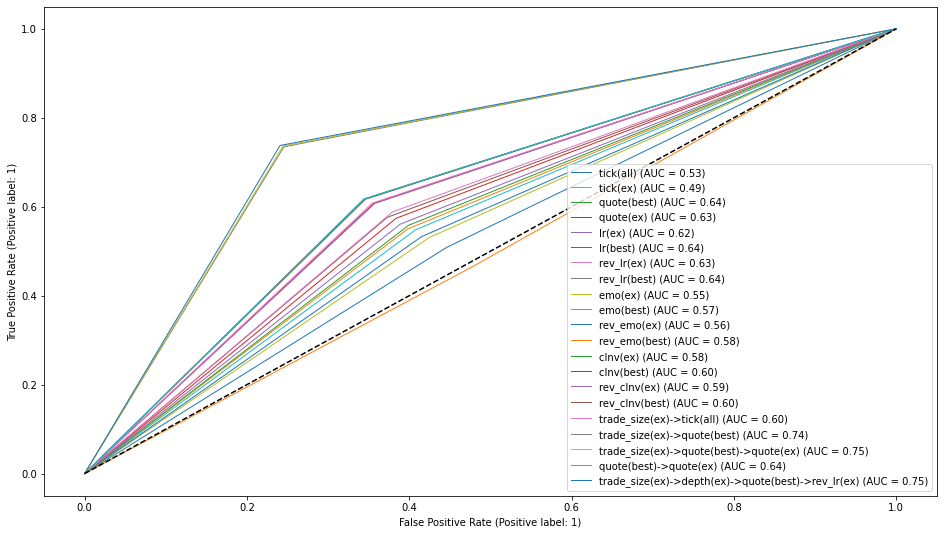

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(16,9))

for name in tqdm(names):
    RocCurveDisplay.from_predictions(
            results[name],
            y_test,
            pos_label=1,
            name=name,
            linewidth=1,
            ax=ax,
        )
plt.plot([0, 1], [0, 1], 'k--', label="random")
plt.show()

In [12]:
results = pd.DataFrame(dict(zip(names, results)), index=X_test.index)

output_path = f"gs://thesis-bucket-option-trade-classification/data/results/{key}.parquet"
results.to_parquet(output_path)

/home/kit/stud/uloak/.local/lib/python3.8/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [13]:
# Log the artifact to save it as an output of this run
result_set = wandb.Artifact(name=key, type="results")
result_set.add_reference(output_path, name="results")
run.log_artifact(result_set)

wandb.finish()

/home/kit/stud/uloak/.local/lib/python3.8/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
